# SVM con *scorings*
Prueba de SVM con los scorings calculados con:
- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

In [1]:
import pandas as pd
import numpy as np

Carga del DataFrame Principal:

In [2]:
data_dir = './B_DATOS'
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")
df_cdk2_labels.head(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.0,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b,0.730317,0.575339,0.634163,0.572172
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.0,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.677828,0.546154,0.571946,0.483032
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.1,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.580543,0.670814,0.607919


Carga de los dataframes con los mejores scores de las proteínas para cada programa de *docking*.

In [3]:
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

## Vinardo

In [4]:
# Caso estudio Vinardo
# Correlación entre las conformaciones
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
sns.set( context = 'talk', style = 'white', palette = "Set2", rc={'figure.figsize':(7, 7)})

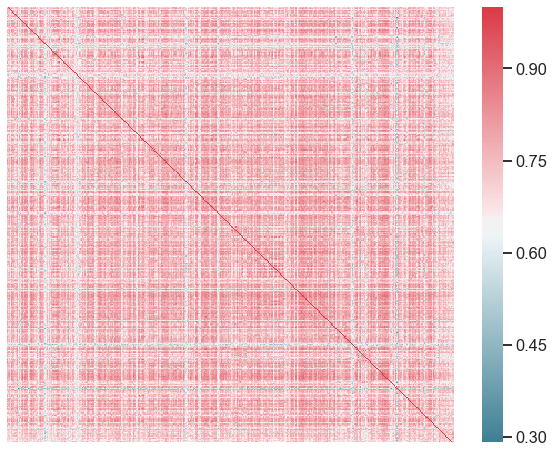

In [43]:
corr = df_vinardo_results.corr()

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap)
ax.set(xticklabels=[])
ax.set(yticklabels=[]);

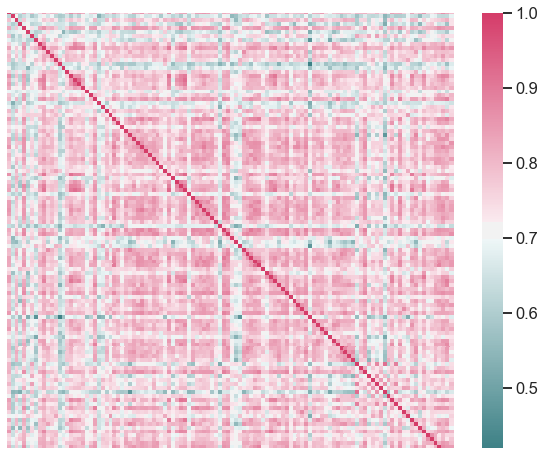

In [42]:
# Selección de las conformaciones activas
conf = "active"
df = df_vinardo_results
active_confs = df_cdk2_labels[df_cdk2_labels.Labels_conf == conf].index

corr = df[active_confs].corr()

f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(200, 0, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap)
ax.set(xticklabels=[])
ax.set(yticklabels=[]);

# SVM Lineal

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [7]:
# Primer intento para vinardo
X = df_vinardo_results.iloc[:, 1:]
y = (df_vinardo_results["ActiveInactive"] == "Active").astype(np.float32)

In [8]:
# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge'))
    ])

In [9]:
# DEfinimos el rango de parámetros para el parámtro C
parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])

C: [0.01, 0.1, 1, 10, 100, 1000, 10000]


In [10]:
from sklearn.model_selection import GridSearchCV
linearSVC = GridSearchCV(SVCpipe, parametros, cv = 5, return_train_score = True)

In [11]:
# Split de los sets de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [12]:
linearSVC.fit(X_train, y_train)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVC',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='hinge', max_iter=1000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
            

In [13]:
bestSVC = linearSVC.best_estimator_

In [14]:
# Seleccionamos el mejor modelo
linearSVC.best_params_

{'SVC__C': 0.1}

In [15]:
# Evaluamos el mejor score
linearSVC.best_score_

0.9545454545454546

In [16]:
# Entrenando el mejor modelo nuevamente
bestSVC.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [17]:
# Exactitud
bestSVC.score(X_train, y_train)

1.0

In [18]:
# Exactitud
bestSVC.score(X_test, y_test)

0.9565217391304348

## SVM lineal con las mejores conformaciones
Seleccionamos las conformaciones con un AUC en vinardo mayor a 0.75

In [50]:
df_best_vinardo_confs = df_cdk2_labels[df_cdk2_labels.AUC_vrd >= 0.75].index
df_best_vinardo_confs.shape

df = df_vinardo_results[best_vinardo_confs] 
X = df.iloc[:, 1:]
y = (df["ActiveInactive"] == "Active").astype(np.float32)
X.shape

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf,AUC_vrd,AUC_vina,AUC_ad4_LC,AUC_ad4_LE
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a,0.764706,0.580543,0.670814,0.607919
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a,0.766968,0.571493,0.764932,0.715385
1di8,the structure of cyclin-dependent kinase 2 (cd...,2000-11-29,1,A,2.20,298,94.966443,2,"[6, 9]","[[37, 42], [153, 161]]",1,['DTQ'],DTQ,282.0,inact_a,0.768552,0.607466,0.662896,0.590271
1dm2,human cyclin-dependent kinase 2 complexed with...,2000-05-31,1,A,2.10,298,91.946309,2,"[9, 15]","[[36, 44], [149, 163]]",2,"['EDO', 'HMD']",HMD,234.0,inact_b,0.770362,0.626471,0.664932,0.644796
1gii,human cyclin dependent kinase 2 complexed with...,2002-02-06,1,A,2.00,295,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",1,['1PU'],1PU,292.0,inact_a,0.793665,0.574661,0.712670,0.614706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5nev,cdk2/cyclin a in complex with compound 73,2017-03-29,2,A,2.97,297,99.328859,1,[3],"[[297, 299]]",2,"['72L', 'TPO']",72L,424.0,dfg_out,0.814253,0.653167,0.689140,0.622398
6guc,cdk2/cyclina in complex with su9516,2018-12-05,2,A,2.00,297,97.986577,2,"[5, 2]","[[37, 41], [297, 298]]",2,"['SU9', 'TPO']",SU9,230.0,active,0.769910,0.568552,0.650000,0.594118
6gue,cdk2/cyclina in complex with azd5438,2018-12-05,3,C,1.99,297,96.979866,3,"[5, 3, 2]","[[226, 230], [243, 245], [297, 298]]",2,"['FB8', 'TPO']",FB8,350.0,active,0.761991,0.626471,0.688235,0.628281
6guf,cdk2/cyclina in complex with cgp74514a,2018-12-05,2,A,2.65,297,99.328859,1,[3],"[[39, 41]]",2,"['23D', 'TPO']",23D,326.0,active,0.836878,0.644344,0.721946,0.658371


In [ ]:
# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge', max_iter = 10000))
    ])

parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])

# Grid par CV
linearSVC = GridSearchCV(SVCpipe, parametros, cv = 5, return_train_score = True)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
linearSVC.fit(X_train, y_train)

## Intento con Vina (peor desempeño que vinardo)

In [19]:
# Primer intento para vinardo
df = df_vina_results
X = df.iloc[:, 1:]
y = (df["ActiveInactive"] == "Active").astype(np.float32)

# Se establece el pipeline para el gridSearch
SVCpipe = Pipeline([
        ("scaler", StandardScaler()),
        ("SVC", LinearSVC(loss = 'hinge', max_iter = 10000))
    ])

parametros = {'SVC__C': [10**i for i in range(-2, 5)]}
print("C:", parametros["SVC__C"])

# Grid par CV
linearSVC = GridSearchCV(SVCpipe, parametros, cv = 5, return_train_score = True)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
linearSVC.fit(X_train, y_train)

C: [0.01, 0.1, 1, 10, 100, 1000, 10000]


/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVC',
                                        LinearSVC(C=1.0, class_weight=None,
                                                  dual=True, fit_intercept=True,
                                                  intercept_scaling=1,
                                                  loss='hinge', max_iter=10000,
                                                  multi_class='ovr',
                                                  penalty='l2',
                                                  random_state=None, tol=0.0001,
                                                  verbose=0))],
           

In [21]:
# Mejor modelo para vina
bestSVC_vina = linearSVC.best_estimator_
# Seleccionamos el mejor modelo
linearSVC.best_params_

{'SVC__C': 0.1}

In [22]:
# Entrenando el mejor modelo nuevamente
bestSVC_vina.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 LinearSVC(C=0.1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=10000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [23]:
# Exactitud Train
bestSVC_vina.score(X_train, y_train)

1.0

In [24]:
# Exactitud Test
bestSVC.score(X_test, y_test)

0.8260869565217391